<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP_2022/blob/main/05%20Deep%20Learning/notebooks/Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolución en imágenes

El objetivo de esta notebook es mostrar ejemplos de como funciona la convolución en imágenes. 

In [100]:
#@title Funciones para la convolución matricial
import numbers
from numpy.lib.stride_tricks import as_strided
import numpy as np

def extract_patches(arr, patch_shape=8, extraction_step=1):
    """Extracts patches of any n-dimensional array in place using strides.
    Given an n-dimensional array it will return a 2n-dimensional array with
    the first n dimensions indexing patch position and the last n indexing
    the patch content. This operation is immediate (O(1)). A reshape
    performed on the first n dimensions will cause numpy to copy data, leading
    to a list of extracted patches.
    Read more in the :ref:`User Guide <image_feature_extraction>`.
    Parameters
    ----------
    arr : ndarray
        n-dimensional array of which patches are to be extracted
    patch_shape : int or tuple of length arr.ndim.default=8
        Indicates the shape of the patches to be extracted. If an
        integer is given, the shape will be a hypercube of
        sidelength given by its value.
    extraction_step : int or tuple of length arr.ndim, default=1
        Indicates step size at which extraction shall be performed.
        If integer is given, then the step is uniform in all dimensions.
    Returns
    -------
    patches : strided ndarray
        2n-dimensional array indexing patches on first n dimensions and
        containing patches on the last n dimensions. These dimensions
        are fake, but this way no data is copied. A simple reshape invokes
        a copying operation to obtain a list of patches:
        result.reshape([-1] + list(patch_shape))
    """

    arr_ndim = arr.ndim

    if isinstance(patch_shape, numbers.Number):
        patch_shape = tuple([patch_shape] * arr_ndim)
    if isinstance(extraction_step, numbers.Number):
        extraction_step = tuple([extraction_step] * arr_ndim)

    patch_strides = arr.strides

    slices = tuple(slice(None, None, st) for st in extraction_step)
    indexing_strides = arr[slices].strides

    patch_indices_shape = (
        (np.array(arr.shape) - np.array(patch_shape)) // np.array(extraction_step)
    ) + 1

    shape = tuple(list(patch_indices_shape) + list(patch_shape))
    strides = tuple(list(indexing_strides) + list(patch_strides))

    patches = as_strided(arr, shape=shape, strides=strides)
    return patches

def conv2d(img, krn):
    '''
    Función que realiza la convolución en una posición de la imágen
    '''
    is0, is1, ks0, ks1 = *img.shape, *krn.shape
    rs0, rs1 = is0 - ks0 + 1, is1 - ks1 + 1
    res = np.zeros((rs0, rs1), dtype = krn.dtype)
    
    for i in range(rs0):
        for j in range(rs1):
            res[i, j] = (krn * img[i : i + ks0, j : j + ks1]).sum()
            
    return res

def convolution(I,K):
    '''
    Función que recorre toda la imágen I realizando la convolución en cada posición
    '''
    C = np.zeros_like(I)
    EI = np.pad(I, [(1,1), (1,1)], mode='constant', constant_values=0)
    submatrices = extract_patches(EI,(3,3))
    for i,row in enumerate(submatrices):
        for j,x in enumerate(row):
            C[i,j] = conv2d_slow(x,K)[0,0]
    return C

## Kernels

Definimos explícitamente algunos kernels de $3\times 3$

In [51]:
K_shift_left = np.array([[0,0,0],[0,0,1],[0,0,0]])
print(K_shift_left)

[[0 0 0]
 [0 0 1]
 [0 0 0]]


In [50]:
x = 1/9
K_blur = np.array([x for j in range(9)]).reshape(3,3)
print(K_blur)

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


In [68]:
K_gaussian_blur = (1/16)*np.array([[1,2,1],[2,4,2],[1,2,1]])
print(K_gaussian_blur)

[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]


In [83]:
K_sharpen = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
print(K_sharpen)

[[ 0 -1  0]
 [-1  5 -1]
 [ 0 -1  0]]


In [87]:
K_edge = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
print(K_edge)

[[-1 -1 -1]
 [-1  8 -1]
 [-1 -1 -1]]


In [97]:
K_sobel_edge = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
print(K_sobel_edge)

[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]


## Toy examples

Aplicamos la convolución a ejemplos pequeños para observar el efecto en las matrices

Definimos una matriz arbitraria

In [102]:
I1 = np.array(range(1,21)).reshape(4,5)
print(I1)

[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]]


Padding

In [104]:
EI = np.pad(I1, [(1,1), (1,1)], mode='constant', constant_values=0)
EI

array([[ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  2,  3,  4,  5,  0],
       [ 0,  6,  7,  8,  9, 10,  0],
       [ 0, 11, 12, 13, 14, 15,  0],
       [ 0, 16, 17, 18, 19, 20,  0],
       [ 0,  0,  0,  0,  0,  0,  0]])

Realizamos la convolución de shift a la izquierda

In [105]:
print("Imagen original:\n",I1)
print("Imagen transformada:\n",convolution(I1,K_shift_left))

Imagen original:
 [[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]]
Imagen transformada:
 [[ 2  3  4  5  0]
 [ 7  8  9 10  0]
 [12 13 14 15  0]
 [17 18 19 20  0]]


Realizamos la convolución con un filtro de desenfoque

In [106]:
print("Imagen original:\n",I1)
print("Imagen transformada:\n",convolution(I1,K_blur))

Imagen original:
 [[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]]
Imagen transformada:
 [[ 1  2  3  4  3]
 [ 4  6  7  9  6]
 [ 7 12 13 14  9]
 [ 6  9 10 11  7]]


## Ejemplos con Imágenes

Ahora, aplicamos los filtros de convolución anteriores a imágenes reales. Usamos imágenes del dataset MNIST.

Funciones para graficar matrices como imágenes

In [78]:
import matplotlib.pyplot as plt

def show_img(X):
    plt.figure()
    plt.imshow(X, cmap='gray')
    plt.axis("Off")
    plt.show()

def show_imgs(X,Z):
    plt.subplot(1, 2, 1)
    plt.imshow(X, cmap='gray')
    plt.title('Before')
    plt.axis("Off")
    plt.subplot(1, 2, 2)
    plt.imshow(Z, cmap='gray')
    plt.title('After')
    plt.axis("Off")
    plt.show()

In [58]:
from tensorflow.keras.datasets import mnist

(X_train, _), (X_test, _) = mnist.load_data()

Escogemos una imagen del dataset MNIST

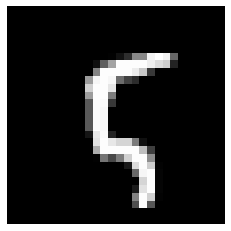

In [90]:
import matplotlib.pyplot as plt

idx = 100
I = X_train[idx]
show_img(I)

**Box Blur**

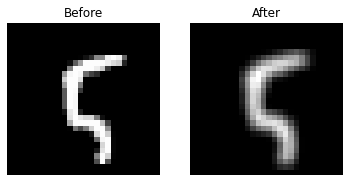

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


In [91]:
It = convolution(I,K_blur)
show_imgs(I,It)
print(K_blur)

**Gaussian Blur**

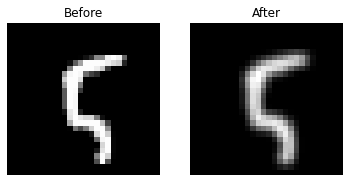

[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]


In [92]:
It = convolution(I,K_gaussian_blur)
show_imgs(I,It)
print(K_gaussian_blur)

**Sharpen**

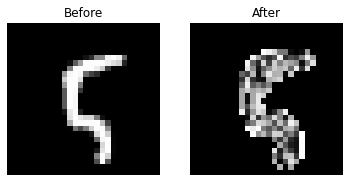

[[ 0 -1  0]
 [-1  5 -1]
 [ 0 -1  0]]


In [93]:
It = convolution(I,K_sharpen)
show_imgs(I,It)
print(K_sharpen)

**Edge dectection**

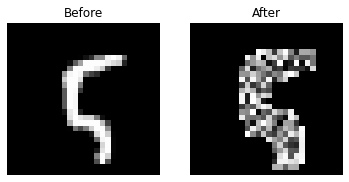

[[-1 -1 -1]
 [-1  8 -1]
 [-1 -1 -1]]


In [94]:
It = convolution(I,K_edge)
show_imgs(I,It)
print(K_edge)

**Edge dectection**

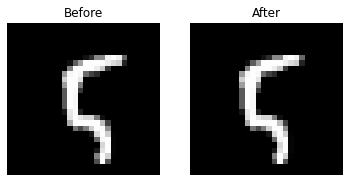

[[0 0 0]
 [0 0 1]
 [0 0 0]]


In [95]:
It = convolution(I,K_shift_left)
show_imgs(I,It)
print(K_shift_left)

**Shift**

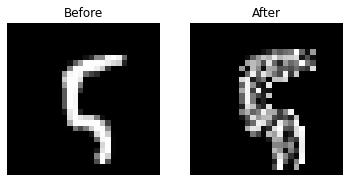

[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]


In [99]:
It = convolution(I,np.transpose(K_sobel_edge))
show_imgs(I,It)
print(K_sobel_edge)